In [503]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path

data_dir = Path('/kaggle/input/march-machine-learning-mania-2024')

MTeams_file = 'MTeams.csv' # Team information
MConfs_file = 'MTeamConferences.csv' # Conference information
MCoachs_file = 'MTeamCoaches.csv' # Coach information
MTSeeds_file = 'MNCAATourneySeeds.csv' # Tournament seed information
MRegStats_file = 'MRegularSeasonDetailedResults.csv' # Game-by-game stats in Regular season
MTouStats_file = 'MNCAATourneyDetailedResults.csv' # Game-by-game stats in Tounament
MRanks_file = 'MMasseyOrdinals_thruSeason2024_day128.csv' # Ranking from different ranking systems
MTSlots_file = 'MNCAATourneySlots.csv' # Tournament slot

# Import data used into dataframe
data_list = ['MTeams', 'MConfs', 'MCoachs', 'MTSeeds', 'MRegStats', 'MTouStats', 'MRanks', 'MTSlots']
for name in data_list:
    file_path = data_dir / globals()[name + '_file']
    globals()[name] = pd.read_csv(file_path)

In [504]:
# Map for DayNum into the meaning
def map_daynum(daynum, season):
    daynum = int(daynum)
    season = int(season)

    if daynum == 154:
        label = 'R6' # Championship
    elif daynum == 152:
        label = 'R5'# Semifinal
    elif daynum >= 0 and daynum <= 132: 
        label = 'RS' # Regular Season
    else:
        if season != 2021:
            label = 'R4' if daynum == 145 or daynum == 146 else \
                    'R3' if daynum == 143 or daynum == 144 else \
                    'R2' if daynum == 138 or daynum == 139 else \
                    'R1' if daynum == 136 or daynum == 137 else \
                    'PI' if daynum == 134 or daynum == 135 else \
                    'Others'
        else:
            label = 'R4' if daynum == 147 or daynum == 148 else \
                    'R3' if daynum == 145 or daynum == 146 else \
                    'R2' if daynum == 139 or daynum == 140 else \
                    'R1' if daynum == 137 or daynum == 138 else \
                    'PI' if daynum == 136 else \
                    'Others'

    return label

def identify_slot(DayCategory, Seed):
    if DayCategory == 'PI':
        slot = 'first4'
    elif DayCategory == 'R1':
        slot = 'R1' + Seed[0] + str(min(int(Seed[1:3]), 17-int(Seed[1:3])))
    elif DayCategory == 'R2':
        slot = 'R2' + Seed[0] + (
            '1' if int(Seed[1:3]) in [1, 16, 8, 9] else \
            '4' if int(Seed[1:3]) in [5, 12, 4, 13] else \
            '3' if int(Seed[1:3]) in [6, 11, 3, 14] else \
            '2' 
        )
    elif DayCategory == 'R3':
        slot = 'R3' + Seed[0] + (
            '1' if int(Seed[1:3]) in [1, 16, 8, 9, 5, 12, 4, 13] else '2'
        )
    elif DayCategory == 'R4':
        slot = 'R4' + Seed[0] + '1'
    elif DayCategory == 'R5':
        slot = 'R5WX' if Seed[0] in ['W', 'X'] else 'R5YZ'
    elif DayCategory == 'R6':
        slot = 'R6CH'
    else:
        slot = 'ERROR'
    
    return slot
        
MTouStats['DayCategory'] = MTouStats.apply(lambda row: map_daynum(row['DayNum'], row['Season']), axis=1)

## Big Picture
Q: How can the tournament results be predicted? \
A: Calculate features for each team under the condition that will affect the winning rate of the team. \
The target variable is the winning probability at a game, predicted by team stats in regular season, conference the team belongs to, and so on. The candidates for features are shown in below:
*    Factors from regular season : Efficiency margin, Winning/losing rate over stronger/weaker opponents, Winning rate at non-home arena
*    Other factors: Conference the team belongs to, Whether the opponent is stronger/weaker(, Coach record)



## Create a target variable and features from non-regular-season data

In [505]:
def make_base_table(TouStats, TSeeds):
    # Create bracket that becomes the basic table for this project
    brackets = TouStats[['Season', 'WTeamID', 'LTeamID', 'DayNum', 'DayCategory']]

    # Add seed for both teams and compare the seed rank to identify which is stronger
    brackets = brackets.merge(TSeeds[['Season', 'TeamID', 'Seed']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    brackets = brackets.merge(TSeeds[['Season', 'TeamID', 'Seed']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
    brackets = brackets.drop(columns=['TeamID_x', 'TeamID_y']).rename(columns={'Seed_x': 'WSeed', 'Seed_y': 'LSeed'})

    # Add slots info
    brackets['Slots'] = brackets.apply(lambda row: identify_slot(row['DayCategory'], row['WSeed']), axis=1)

    # Sort columns
    brackets = brackets[['Season', 'DayNum','DayCategory', 'Slots', 'WSeed', 'LSeed', 'WTeamID', 'LTeamID']]

    return brackets

def add_StrengthAndConference(base_data, Confs):
    # Merge conference information to data
    df = base_data.merge(Confs, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    df = df.merge(Confs, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
    df = df.drop(columns=['TeamID_x', 'TeamID_y']).rename(columns={'ConfAbbrev_x': 'WConf', 'ConfAbbrev_y': 'LConf'})

    # Abandon W/L columns and replace them to S/W(Stronger/Weaker) seed and team columns respectively
    # And add FavWin flag that is 1 if a stronger team wins otherwise 0
    for i, row in df.iterrows():
        df.loc[i, 'FavWin'] = 1
        cond1 = int(row['WSeed'][1:3]) > int(row['LSeed'][1:3]) # Stronger seed team is assigned to stronger seed
        cond2 = (int(row['WSeed'][1:3]) == int(row['LSeed'][1:3])) and (row['WSeed'][0] > row['LSeed'][0]) # Prioritzie earlier group if two teams come from different groups
        cond3 = (row['DayCategory']=='PI' and row['WSeed'][3]=='b') # a team is assigned to stronger team about First-Four

        if cond1 or cond2 or cond3:
            df.loc[i, 'WSeed'], df.loc[i, 'LSeed'] = row['LSeed'], row['WSeed']
            df.loc[i, 'WTeamID'], df.loc[i, 'LTeamID'] = row['LTeamID'], row['WTeamID']
            df.loc[i, 'WConf'], df.loc[i, 'LConf'] = row['LConf'], row['WConf']
            df.loc[i, 'FavWin'] = 0

    # Change column name into S/W
    df.rename(columns={'WSeed': 'SSeed', 'LSeed': 'WSeed', 
                             'WTeamID': 'STeamID', 'LTeamID': 'WTeamID',
                             'WConf': 'SConf', 'LConf': 'WConf'}, inplace=True)

    # Create StrengthDiff variable that is the seed difference between two teams 
    df['StrengthDiff'] = - (df['SSeed'].str.slice(1, 3).astype(int) - df['WSeed'].str.slice(1, 3).astype(int))

    return df

def make_conference_record(base_data):
    # Divide conferences into 3 groups (1, 2, 3) based on the winning record
    confs_record1 = base_data[(base_data['Season']>=2012)&(base_data['FavWin']==1)][['SConf']].value_counts().reset_index()
    confs_record2 = base_data[(base_data['Season']>=2012)&(base_data['FavWin']==0)][['WConf']].value_counts().reset_index()

    confs_record = pd.merge(confs_record1, confs_record2, left_on='SConf', right_on='WConf', how='outer').fillna(0)
    confs_record['Conf'] = np.where(confs_record['SConf']==0, confs_record['WConf'], confs_record['SConf'])
    confs_record['TotalWin'] = confs_record['count_x'] + confs_record['count_y']
    confs_record = confs_record[['Conf', 'TotalWin']].sort_values('TotalWin', ascending=False)

    # Set the edges of bin to divide into 3 groups as 10 and 50
    confs_record['Group'] = pd.cut(confs_record['TotalWin'], bins=[0, 10, 50, np.inf], labels=range(1, 4), right=False).astype(int)

    return confs_record

def merge_conference_record(base_data, confs_record):
    # Combine confs_record to basic table
    base_data = base_data.merge(confs_record[['Conf', 'Group']], left_on='SConf', right_on='Conf', how='left')
    base_data = base_data.merge(confs_record[['Conf', 'Group']], left_on='WConf', right_on='Conf', how='left')
    base_data = base_data.fillna(0).drop(columns=['Conf_x', 'Conf_y']).rename(columns={'Group_x': 'SGroup', 'Group_y': 'WGroup'})

    # Then compute ConfGroupDiff as stronger-seed team's group - weaker-seed team's group
    base_data['ConfStrengthDiff'] = base_data['SGroup'] - base_data['WGroup']

    return base_data
    
base_data = make_base_table(MTouStats, MTSeeds)
base_data = add_StrengthAndConference(base_data, MConfs)
confs_record = make_conference_record(base_data)
base_data = merge_conference_record(base_data, confs_record)

base_data

,Season,DayNum,DayCategory,Slots,SSeed,WSeed,STeamID,WTeamID,SConf,WConf,FavWin,StrengthDiff,SGroup,WGroup,ConfStrengthDiff
0,2003,134,PI,first4,X16a,X16b,1411,1421,swac,big_south,0.0,0,1.0,1.0,0.0
1,2003,136,R1,R1Z1,Z01,Z16,1112,1436,pac_ten,aec,1.0,15,0.0,1.0,-1.0
2,2003,136,R1,R1Z7,Z07,Z10,1272,1113,cusa,pac_ten,0.0,3,2.0,0.0,2.0
3,2003,136,R1,R1Z6,Z06,Z11,1166,1141,mvc,mac,0.0,5,2.0,1.0,1.0
4,2003,136,R1,R1W8,W08,W09,1143,1301,pac_ten,acc,1.0,1,0.0,3.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,R4,R4Y1,Y02,Y05,1400,1274,big_twelve,acc,0.0,3,3.0,3.0,0.0
1311,2023,146,R4,R4X1,X05,X06,1361,1166,mwc,big_east,1.0,1,2.0,3.0,-1.0
1312,2023,152,R5,R5YZ,Z04,Y05,1163,1274,big_east,acc,1.0,1,3.0,3.0,0.0
1313,2023,152,R5,R5WX,X05,W09,1361,1194,mwc,cusa,1.0,4,2.0,2.0,0.0


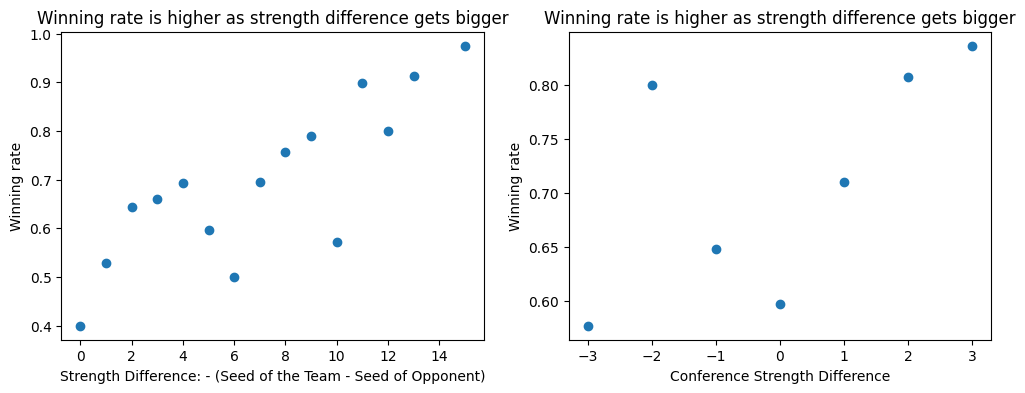

In [506]:
# winning probability of stronger seed
df =  base_data[['StrengthDiff', 'FavWin']].groupby('StrengthDiff').mean().sort_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(df.index, df['FavWin'])
plt.title('Winning rate is higher as strength difference gets bigger')
plt.xlabel('Strength Difference: - (Seed of the Team - Seed of Opponent)')
plt.ylabel('Winning rate')

# winning probability of stronger conference
df =  base_data[['ConfStrengthDiff', 'FavWin']].groupby('ConfStrengthDiff').mean().sort_index()

plt.subplot(1, 2, 2)
plt.scatter(df.index, df['FavWin'])
plt.title('Winning rate is higher as strength difference gets bigger')
plt.xlabel('Conference Strength Difference')
plt.ylabel('Winning rate')
plt.show()

## Create and add features needed for prediction using regular season data

In [507]:
def develop_RS_stats(RegStats):
    # Create a dataframe for wins and losses
    wins = MRegStats[['Season', 'WTeamID', 'DayNum']].copy()
    losses = MRegStats[['Season', 'LTeamID', 'DayNum']].copy()

    # Rename columns for a unified view
    wins.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
    losses.rename(columns={'LTeamID': 'TeamID'}, inplace=True)

    # Mark wins and losses
    wins['Result'] = 1
    losses['Result'] = 0

    # Combine wins and losses into a single dataframe
    results = pd.concat([wins, losses], ignore_index=True).sort_values(by=['Season', 'TeamID', 'DayNum']).reset_index(drop=True)

    # Calculate cumulative wins and games played for each game
    results['PrevWins'] = results.groupby(['Season', 'TeamID'])['Result'].transform(lambda x: x.cumsum().shift(fill_value=0))
    results['PrevGamesPlayed'] = results.groupby(['Season', 'TeamID']).cumcount()
    results['WinRate'] = (results['PrevWins'] / results['PrevGamesPlayed']).fillna(0.5)

    # Merge the winning rate information back into the original data for both winning and losing teams
    stats_data = MRegStats.merge(results[['Season', 'TeamID', 'DayNum', 'WinRate', 'PrevGamesPlayed']], left_on=['Season', 'WTeamID', 'DayNum'], right_on=['Season', 'TeamID', 'DayNum'], how='left')
    stats_data.rename(columns={'WinRate': 'WWinRate', 'PrevGamesPlayed': 'WPrevGP'}, inplace=True)
    stats_data.drop('TeamID', axis=1, inplace=True)

    stats_data = stats_data.merge(results[['Season', 'TeamID', 'DayNum', 'WinRate', 'PrevGamesPlayed']], left_on=['Season', 'LTeamID', 'DayNum'], right_on=['Season', 'TeamID', 'DayNum'], how='left')
    stats_data.rename(columns={'WinRate': 'LWinRate', 'PrevGamesPlayed': 'LPrevGP'}, inplace=True)
    stats_data.drop('TeamID', axis=1, inplace=True)

    # Finally calculate the difference of winnig rates between winning and losing team
    stats_data['WUpset'] = np.where((stats_data['WWinRate'] - stats_data['LWinRate'] < -0.1) & (stats_data['WPrevGP'] >= 5) & (stats_data['LPrevGP'] >= 5), 1, 0)
    stats_data['LUpset'] = stats_data['WUpset']
    
    # Winning at non-home arena or not
    # In most cases, tournament games will be held at arena playes are not familiar with. Then, the winning rate will be somewhat effective.
    stats_data['WNonHome'] = np.where(stats_data['WLoc']!='H', 1, 0)
    stats_data['LNonHome'] = 0
    
    # Possession Score
    # Basic Possession Formula=0.96*[(Field Goal Attempts)+(Turnovers)+0.44*(Free Throw Attempts)-(Offensive Rebounds)]
    stats_data['WPoss'] = 0.96 * (stats_data['WFGA'] + stats_data['WTO'] + 0.44 * stats_data['WFTA'] - stats_data['WOR'])
    stats_data['LPoss'] = 0.96 * (stats_data['LFGA'] + stats_data['LTO'] + 0.44 * stats_data['LFTA'] - stats_data['LOR'])

    # Offensive Efficiency
    stats_data['WOffEff'] = 100 * (stats_data['WScore'] / stats_data['WPoss'])
    stats_data['LOffEff'] = 100 * (stats_data['LScore'] / stats_data['LPoss'])
    stats_data['WDffEff'] = stats_data['LOffEff']
    stats_data['LDffEff'] = stats_data['WOffEff']

    return stats_data

stats_data = develop_RS_stats(MRegStats)
stats_data

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WUpset,LUpset,WNonHome,LNonHome,WPoss,LPoss,WOffEff,LOffEff,WDffEff,LDffEff
0,2003,10,1104,68,1328,62,N,0,27,58,...,0,0,1,0,71.9232,67.8528,94.545293,91.374269,91.374269,94.545293
1,2003,10,1272,70,1393,63,N,0,26,62,...,0,0,1,0,65.6256,65.0880,106.665691,96.792035,96.792035,106.665691
2,2003,11,1266,73,1437,61,N,0,24,58,...,0,0,1,0,61.2096,61.5552,119.262338,99.098045,99.098045,119.262338
3,2003,11,1296,56,1457,50,N,0,18,38,...,0,0,1,0,55.3344,55.2960,101.202868,90.422454,90.422454,101.202868
4,2003,11,1400,77,1208,71,N,0,30,61,...,0,0,1,0,61.1712,60.3648,125.876229,117.618215,117.618215,125.876229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113236,2024,132,1120,86,1196,67,N,0,31,61,...,0,0,1,0,73.6128,72.0000,116.827508,93.055556,93.055556,116.827508
113237,2024,132,1182,57,1433,51,N,0,17,57,...,0,0,1,0,57.8304,57.7536,98.564077,88.306184,88.306184,98.564077
113238,2024,132,1228,93,1458,87,N,0,30,57,...,0,0,1,0,63.5520,65.3952,146.336858,133.037287,133.037287,146.336858
113239,2024,132,1412,85,1396,69,N,0,31,63,...,0,0,1,0,68.8128,68.6208,123.523531,100.552602,100.552602,123.523531


### Aggregate data by season and team

In [508]:
def aggregate_stats_data(stats_data):
    # Just for convenience
    stats_data['cnt'] = 1

    vals = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 
            'TO', 'Stl', 'Blk', 'PF', 'Upset', 'NonHome', 'Poss', 'OffEff', 'DffEff', 'cnt']

    win_vals = ['W'+name if name != 'cnt' else name for name in vals]
    agg_win = stats_data.groupby(['Season', 'WTeamID'])[win_vals].sum()
    agg_win.rename_axis(index={'WTeamID': 'TeamID'}, inplace=True) 
    agg_win.rename(columns={wval: val if (val != 'Upset') else 'W'+val for wval, val in zip(win_vals, vals)}, inplace=True)

    lose_vals = ['L'+name if name != 'cnt' else name for name in vals]
    agg_lose = stats_data.groupby(['Season', 'LTeamID'])[lose_vals].sum()
    agg_lose.rename_axis(index={'LTeamID': 'TeamID'}, inplace=True) 
    agg_lose.rename(columns={lval: val if (val != 'Upset') else 'L'+val for lval, val in zip(lose_vals, vals)}, inplace=True)

    agg_all = pd.concat([agg_win, agg_lose], axis=0)
    agg_all = agg_all.groupby(['Season', 'TeamID']).sum()

    agg_all = agg_all.div(agg_all['cnt'], axis=0).drop(columns='cnt')

    # Add num of win/lose game for each team
    agg_all = pd.merge(agg_all, agg_win['cnt'], left_index=True, right_index=True, how='left')
    agg_all.rename(columns={'cnt': 'NumWin'}, inplace=True)

    agg_all = pd.merge(agg_all, agg_lose['cnt'], left_index=True, right_index=True, how='left')
    agg_all.rename(columns={'cnt': 'NumLose'}, inplace=True)
    agg_all.fillna(0, inplace=True)

    # Add efficiency margin
    agg_all['EffMargin'] = agg_all['OffEff'] - agg_all['DffEff']

    # Add winning rate
    agg_all['WinRate'] = agg_all['NumWin'] / (agg_all['NumWin'] + agg_all['NumLose'])

    agg_all.reset_index(inplace=True)
    
    return agg_all

RS_stats = aggregate_stats_data(stats_data)
RS_stats.head()

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,...,WUpset,NonHome,Poss,OffEff,DffEff,LUpset,NumWin,NumLose,EffMargin,WinRate
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,...,0.035714,0.107143,52.380343,109.273561,109.522922,0.035714,12.0,16.0,-0.249361,0.428571
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,...,0.148148,0.148148,67.275378,116.651118,116.489034,0.148148,13.0,14.0,0.162084,0.481481
2,2003,1104,69.285714,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,...,0.035714,0.142857,63.457371,108.882967,103.099630,0.142857,17.0,11.0,5.783337,0.607143
3,2003,1105,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,...,0.038462,0.076923,73.326277,97.856445,106.384802,0.153846,7.0,19.0,-8.528357,0.269231
4,2003,1106,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,...,0.035714,0.178571,64.588800,98.405306,99.544614,0.142857,13.0,15.0,-1.139308,0.464286


## Merge the additional feature dataframe with the basic dataframe

In [518]:
def merge_features(base_data, RS_stats):
    vals_used = ['WinRate', 'Poss', 'EffMargin', 'WUpset', 'LUpset', 'NonHome']
    all_data = base_data.merge(RS_stats[['Season', 'TeamID']+vals_used], left_on=['Season', 'STeamID'], right_on=['Season', 'TeamID'], how='left')
    all_data.rename(columns={val:'S'+val for val in vals_used}, inplace=True)
    all_data.drop(columns=['TeamID', 'SWUpset'], inplace=True) # don't need to have WUpset for stronger team

    all_data = all_data.merge(RS_stats[['Season', 'TeamID']+vals_used], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    all_data.rename(columns={val:'W'+val for val in vals_used}, inplace=True)
    all_data.drop(columns=['TeamID', 'WLUpset'], inplace=True) # don't need to have LUpset for weaker team

    # Set WUpset/LUpset to 0 if the StrengthDiff is less than 2 because there won't be big strength-reputation difference then
    all_data['SLUpset'] = np.where(all_data['StrengthDiff']<2, 0, all_data['SLUpset'])
    all_data['WWUpset'] = np.where(all_data['StrengthDiff']<2, 0, all_data['WWUpset'])
    
    # Add Possesion and EffMargin difference
    all_data['PossDiff'] = all_data['SPoss'] - all_data['WPoss']    
    all_data['EffMarginDiff'] = all_data['SEffMargin'] - all_data['WEffMargin']

    return all_data

all_data = merge_features(base_data, RS_stats)
all_data

,Season,DayNum,DayCategory,Slots,SSeed,WSeed,STeamID,WTeamID,SConf,WConf,...,SEffMargin,SLUpset,SNonHome,WWinRate,WPoss,WEffMargin,WWUpset,WNonHome,PossDiff,EffMarginDiff
0,2003,134,PI,first4,X16a,X16b,1411,1421,swac,big_south,...,4.530819,0.000000,0.233333,0.448276,67.136441,-10.364803,0.000000,0.103448,-0.241081,14.895622
1,2003,136,R1,R1Z1,Z01,Z16,1112,1436,pac_ten,aec,...,20.166553,0.107143,0.392857,0.655172,62.945545,7.394854,0.000000,0.344828,10.323027,12.771699
2,2003,136,R1,R1Z7,Z07,Z10,1272,1113,cusa,pac_ten,...,12.803865,0.103448,0.310345,0.620690,65.988414,11.382669,0.103448,0.206897,1.018262,1.421196
3,2003,136,R1,R1Z6,Z06,Z11,1166,1141,mvc,mac,...,21.965093,0.090909,0.363636,0.793103,68.563862,8.788468,0.000000,0.413793,-2.561244,13.176626
4,2003,136,R1,R1W8,W08,W09,1143,1301,pac_ten,acc,...,6.944026,0.000000,0.275862,0.600000,64.133120,6.424632,0.000000,0.166667,3.299928,0.519394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,146,R4,R4Y1,Y02,Y05,1400,1274,big_twelve,acc,...,15.942217,0.088235,0.264706,0.781250,66.680400,11.866914,0.000000,0.281250,1.458141,4.075303
1311,2023,146,R4,R4X1,X05,X06,1361,1166,mwc,big_east,...,11.425427,0.000000,0.375000,0.636364,66.828800,13.370850,0.000000,0.242424,-2.402000,-1.945424
1312,2023,152,R5,R5YZ,Z04,Y05,1163,1274,big_east,acc,...,20.493671,0.000000,0.303030,0.781250,66.680400,11.866914,0.000000,0.281250,-0.553273,8.626757
1313,2023,152,R5,R5WX,X05,W09,1361,1194,mwc,cusa,...,11.425427,0.000000,0.375000,0.906250,66.531600,19.969890,0.000000,0.437500,-2.104800,-8.544464


## Exploratory Analysis

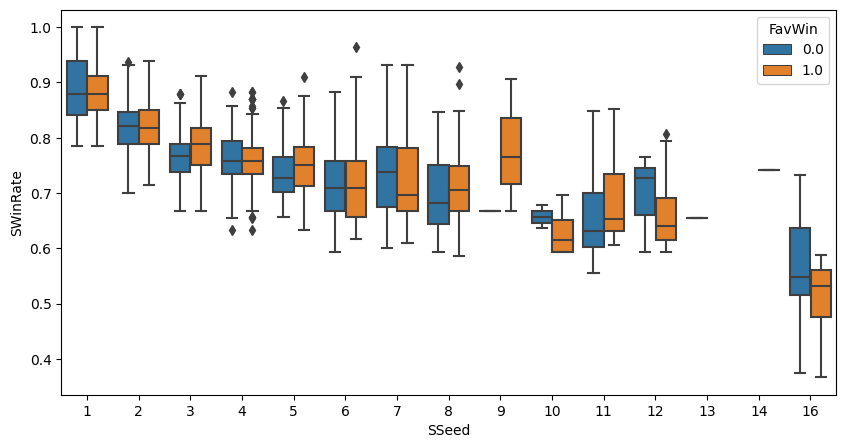

In [519]:
import seaborn as sns

#How is the correlation between win-rate in regular season and seed?
sseed = all_data['SSeed'].str.slice(1,3).astype(int)
swinrate = all_data['SWinRate']

plt.figure(figsize=(10, 5))
sns.boxplot(y=swinrate, x=sseed, hue=all_data['FavWin'])
plt.show()

It seems that WinRate in regular season does not affect Winning rate in tournament.\
(or the factor might be absorbed in seed)

Then, I do not use SWinRate/WWinRate variables for simplicity.

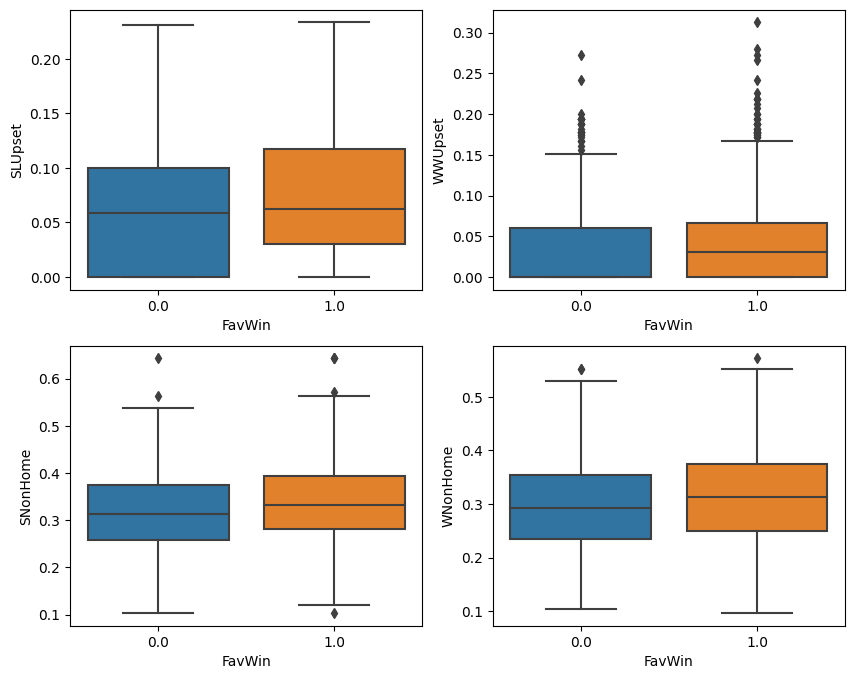

In [520]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.boxplot(y=all_data['SLUpset'], x=all_data['FavWin'])
plt.subplot(2, 2, 2)
sns.boxplot(y=all_data['WWUpset'], x=all_data['FavWin'])
plt.subplot(2, 2, 3)
sns.boxplot(y=all_data['SNonHome'], x=all_data['FavWin'])
plt.subplot(2, 2, 4)
sns.boxplot(y=all_data['WNonHome'], x=all_data['FavWin'])
plt.show()

It seems that upset variables don't work well. I'll also remove two NonHomes.

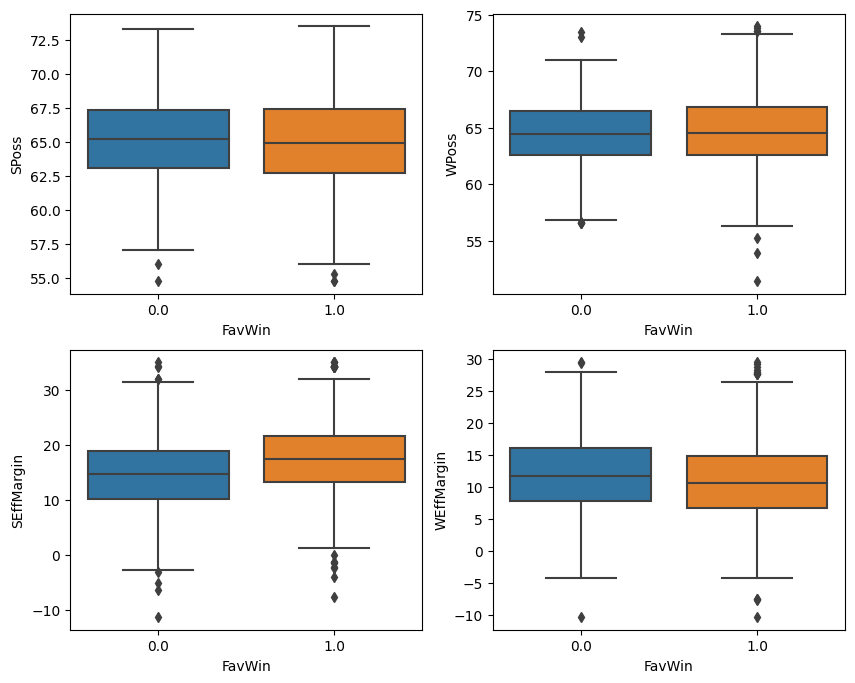

In [523]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.boxplot(y=all_data['SPoss'], x=all_data['FavWin'])
plt.subplot(2, 2, 2)
sns.boxplot(y=all_data['WPoss'], x=all_data['FavWin'])

plt.subplot(2, 2, 3)
sns.boxplot(y=all_data['SEffMargin'], x=all_data['FavWin'])
plt.subplot(2, 2, 4)
sns.boxplot(y=all_data['WEffMargin'], x=all_data['FavWin'])
plt.show()

As shown in the plots above, High EffMargin appears to correlate with high winning rate. \
It'll be better that two EffMargin are combined.\
Possesion will not be useful for predction.

In [292]:
# Baseline of accuracy
# Case where stronger seed wins
baseline_results = all_data['Slots'].str.slice(2,3) + '0' + all_data['Slots'].str.slice(3,4)

baseline = round((all_data['FavWin']==1).sum()/len(all_data), 4)
print(f'Baseline of Accuracy: {baseline}')

Baseline of Accuracy: 0.6928


## Modeling

In [528]:
# Finalize variables used and drop other variables
features = ['StrengthDiff', 'ConfStrengthDiff', 'EffMarginDiff']# , 'SNonHome', 'WNonHome', 'SLUpset', 'WWUpset'] 
target = 'FavWin'
finalized_data = all_data[['Season', 'Slots', 'SSeed', 'WSeed'] + features + [target]]

finalized_data.iloc[:, 4:].corr()

,StrengthDiff,ConfStrengthDiff,EffMarginDiff,FavWin
StrengthDiff,1.000000,0.511402,0.458872,0.302790
ConfStrengthDiff,0.511402,1.000000,0.004767,0.163772
EffMarginDiff,0.458872,0.004767,1.000000,0.240221
FavWin,0.302790,0.163772,0.240221,1.000000


In [544]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

y = finalized_data['FavWin'].values
X = finalized_data.iloc[:, 4:-1]

# Split dataset into train and test data in a 9:1
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize variables
scaler = StandardScaler()
scaled_Xtrain = scaler.fit_transform(Xtrain)
scaled_Xtest = scaler.transform(Xtest)

# Set ML model and fit the data prepared
lr = LogisticRegression(random_state=42)
sv = SVC(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

classifiers = [lr, sv, rf, gb]
for cls in classifiers:
    cv_scores = cross_val_score(cls, scaled_Xtrain, ytrain, cv=5)
    
    print(f"{cls}: {round(cv_scores.mean(), 3)}")

LogisticRegression(random_state=42): 0.699
SVC(random_state=42): 0.707
RandomForestClassifier(random_state=42): 0.628
GradientBoostingClassifier(random_state=42): 0.684


In [545]:
# hyperparameters for each model
param_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_sv = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['poly', 'rbf'],
    'degree': range(1, 4)
}

param_rf = {
    'n_estimators':[600, 700, 800, 900],
    'max_depth': range(4, 7),
    'max_features': ['sqrt', 'log2']    
}

param_gb = {
    'learning_rate':[0.001, 0.01, 0.1], 
    'n_estimators':[300, 500, 700],
    'max_depth':range(1,4)
}

models = [(lr, param_lr), (sv, param_sv), (rf, param_rf), (gb, param_gb)]

# Search best parameter/model by GridSearchCV
best_model = None
best_score = 0
best_param = {}

for model, param in models:
    grid = GridSearchCV(model, param, cv=5, scoring='accuracy')
    grid.fit(scaled_Xtrain, ytrain)

    if grid.best_score_ > best_score:
        best_model = model
        best_score = grid.best_score_
        best_param = grid.best_params_
        
    print("Best Parameters for %s: %s" % (model, grid.best_params_))
    print("Best Score %s: %.3f" % (model, grid.best_score_))
    
print()
print(f"Best model is {best_model}")

Best Parameters for LogisticRegression(random_state=42): {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best Score LogisticRegression(random_state=42): 0.701
Best Parameters for SVC(random_state=42): {'C': 10, 'degree': 1, 'kernel': 'rbf'}
Best Score SVC(random_state=42): 0.708
Best Parameters for RandomForestClassifier(random_state=42): {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 800}
Best Score RandomForestClassifier(random_state=42): 0.710
Best Parameters for GradientBoostingClassifier(random_state=42): {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Best Score GradientBoostingClassifier(random_state=42): 0.703

Best model is RandomForestClassifier(random_state=42)


In [546]:
cls = best_model
cls.set_params(**best_param)

cls.fit(scaled_Xtrain, ytrain)
print(f"Accuracy: {round(cls.score(scaled_Xtest, ytest), 3)}")

Accuracy: 0.712


## Prediction

In [547]:
Seeds2024 = '2024_tourney_seeds.csv' # seeds and teams 2024
Prediction = 'sample_submission.csv' # Submit format

seeds2024 = pd.read_csv(data_dir / Seeds2024)
prediction = pd.read_csv(data_dir / Prediction)

# Create 2024 bracket table
seeds2024['Season'] = 2024
mseeds2024 = seeds2024[seeds2024['Tournament']=='M'].drop(columns='Tournament')

mtslots2024 = MTSlots[(MTSlots['Season']==2024) & (MTSlots['Slot'].str.len()==4)]
mtslots2024['DayCategory'] = mtslots2024['Slot'].str.slice(0,2)


# For Men

# Predict round-by-round from R1 to R6 (Championship)
Round = ['R'+str(i) for i in range(1, 7)]
result_table = mtslots2024.copy().reset_index(drop=True)

for i in range(len(Round)):
    current_round_df = result_table[result_table['DayCategory']==Round[i]]

    # Add teamid to df
    current_round_df = current_round_df.merge(mseeds2024, left_on=['Season', 'StrongSeed'], right_on=['Season', 'Seed'], how='left')
    current_round_df = current_round_df.merge(mseeds2024, left_on=['Season', 'WeakSeed'], right_on=['Season', 'Seed'], how='left')
    current_round_df = current_round_df.drop(columns=['Seed_x', 'Seed_y']).rename(columns={'StrongSeed': 'WSeed', 'WeakSeed': 'LSeed', 'TeamID_x': 'WTeamID', 'TeamID_y': 'LTeamID'})

    # Add features related to strength and conference in the same way as training data
    current_round_df = add_StrengthAndConference(current_round_df, MConfs)
    current_round_df.drop(columns='FavWin', inplace=True)
    
    current_round_df = merge_conference_record(current_round_df, confs_record)

    # Add other features from regular season stats data
    current_round_all_data = merge_features(current_round_df, RS_stats)

    # Data used for prediction
    current_round_data_used = current_round_all_data[['Season', 'Slot', 'SSeed', 'WSeed'] + features]

    X2024 = current_round_data_used.iloc[:, 4:]
    scaled_X2024 = scaler.transform(X2024)
    
    # ML model used for prediction
    rf = RandomForestClassifier()
    rf.fit(scaled_Xtrain, ytrain)

    pred_df = pd.DataFrame({
        'Slot': current_round_df['Slot'],
        'Pred_Winner': rf.predict(scaled_X2024)})
    
    # Write the prediction results onto result_table and prediction dfs
    for i, row in pred_df.iterrows():
        if row['Pred_Winner'] == 1:
            winner = result_table.loc[result_table['Slot']==row['Slot'], 'StrongSeed'].values[0]
            
            if row['Slot'] in result_table['StrongSeed'].values:
                result_table.loc[result_table['StrongSeed']==row['Slot'], 'StrongSeed'] = winner
            else:
                result_table.loc[result_table['WeakSeed']==row['Slot'], 'WeakSeed'] = winner
        else:
            winner = result_table.loc[result_table['Slot']==row['Slot'], 'WeakSeed'].values[0]
            
            if row['Slot'] in result_table['StrongSeed'].values:
                result_table.loc[result_table['StrongSeed']==row['Slot'], 'StrongSeed'] = winner
            else:
                result_table.loc[result_table['WeakSeed']==row['Slot'], 'WeakSeed'] = winner
    
    
        prediction.loc[(prediction['Tournament']=='M')&(prediction['Slot']==row['Slot']), 'Team'] = winner

/tmp/ipykernel_33/3068193061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtslots2024['DayCategory'] = mtslots2024['Slot'].str.slice(0,2)


In [549]:
prediction

,RowId,Tournament,Bracket,Slot,Team
0,0,M,1,R1W1,W01
1,1,M,1,R1W8,W09
2,2,M,1,R1W5,W05
3,3,M,1,R1W4,W04
4,4,M,1,R1W6,W11
...,...,...,...,...,...
121,121,W,1,R4Y1,Y01
122,122,W,1,R4Z1,Z01
123,123,W,1,R5WX,W01
124,124,W,1,R5YZ,Y01


In [548]:
prediction.to_csv('submission_00.csv')